# Quick Start - Human Endometrium

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/quick_start_human.ipynb)

In this tutorial, we will use the Human Endometrial Cell Atlas (HECA) dataset [(Mareckova & Garcia-Alonso et al 2023)](https://doi.org/10.1038/s41588-024-01873-w) to explore the metabolic pathways of cell types present across the menstrual cycle.

The dataset we are using is a [downsampled version of the HECA](https://zenodo.org/records/15072628/files/HECA-Subset.h5ad) found in [The Repoductive Cell Atlas](https://www.reproductivecellatlas.org/).

Here we cover mainly basic visualizations of metabolic tasks. **For additional downstream analyses**, please visit our **Extended Tutorials**. A good starting point is our **[General Overview Tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/extended_quick_start.html)**, which will get you started with some downstream analyses.

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading endometrium data](#loading-endometrium-data)
* [Run scCellFie](#run-sccellfie)
* [Export results](#export-results)
* [Visualization of results](#visualization-of-results)

## Loading libraries <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

## Loading endometrium data <a class="anchor" id="loading-endometrium-data"></a>

The downsampled Human Endometrial Cell Atlas contains ~90k cells `(n_obs)` with 17,736 genes `(n_vars)`.

This is a processed data, with raw count matrix stored in `.X`, including 36 cell type annotations in `.obs['celltype']`.

In [2]:
adata = sc.read(filename='./data/HECA-Subset.h5ad',
                backup_url='https://zenodo.org/records/15072628/files/HECA-Subset.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 90001 × 17736
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    var: 'gene_ids', 'feature_types'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'phase_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

In current version, scCellFie supports `human` or `mouse` specific metabolic pathways. We will select `organism='human'` for the analysis.

In [4]:
results = sccellfie.run_sccellfie_pipeline(adata,
                                           organism='human', 
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', # Total counts per cell will be computed if left as None, 
                                           process_by_group=False, # Whether to do the processing by cell groups
                                           groupby=None, # Column indicating cell groups if `process_by_group=True`
                                           neighbors_key='neighbors', # Neighbors information if precomputed. Otherwise, it will be computed here
                                           n_neighbors=10, # Number of neighbors to use
                                           batch_key=None, # there is no batch_key in this dataset 
                                           threshold_key='sccellfie_threshold',  # This is for using the default database. If personalized thresholds are used, specificy column name
                                           smooth_cells=True, # Whether to perform gene expression smoothing before running the tool
                                           alpha=0.33, # Importance of neighbors' expression for the smoothing (0 to 1)
                                           chunk_size=5000, # Number of chunks to run the processing steps (helps with the memory)
                                           disable_pbar=False, 
                                           save_folder=None, # In case results will be saved. If so, results will not be returned and should be loaded from the folder (see sccellfie.io.load_data function
                                           save_filename=None # Name for saving the files, otherwise a default name will be used
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (90001, 839)
Number of GPRs: 748
Shape of tasks by genes: (215, 839)
Shape of reactions by genes: (748, 839)
Shape of tasks by reactions: (215, 748)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 19/19 [00:47<00:00,  2.49s/it]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 90001/90001 [07:37<00:00, 196.72it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 0 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Export results <a class="anchor" id="export-results"></a>

In [5]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

To access metabolic activities, we need to inspect ``results['adata']``:

- The processed single-cell data is located in the AnnData object ``results['adata']``.
- The reaction activities for each cell are located in the AnnData object ``results['adata'].reactions``.
- The metabolic task activities for each cell are located in the AnnData object ``results['adata'].metabolic_tasks``.

In particular:

- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Other keys in the ``results`` dictionary are associated with the scCellFie database and are already filtered for the elements present
in the dataset (``'gpr_rules'``, ``'task_by_gene'``, ``'rxn_by_gene'``, ``'task_by_rxn'``, ``'rxn_info'``, ``'task_info'``, ``'thresholds'``, ``'organism'``).

### Save single-cell results

We can save our single-cell results contained in the AnnData objects (``results['adata']``) into a specific folder. Here we only need to specify the output folder, and the basename that our AnnData objects will have. This function below saves the expression object (``results['adata']``) and those containing scores for reactions and metabolic tasks (``results['adata'].reactions`` and ``results['adata'].metabolic_tasks``, respectively), as separate files.

In [6]:
sccellfie.io.save_adata(adata=results['adata'], output_directory='./results/', filename='Human_HECA_scCellFie')

./results//Human_HECA_scCellFie.h5ad was correctly saved
./results//Human_HECA_scCellFie_reactions.h5ad was correctly saved
./results//Human_HECA_scCellFie_metabolic_tasks.h5ad was correctly saved


## Visualization of results <a class="anchor" id="visualization-of-results"></a>

scCellFie implements multiple visualizations, sometimes building upon Scanpy functionalities. To showcase these visualizations, we first start defining where to find our cell-type annotations in the dataset, and defining a palette of colors for them.

In [7]:
# Column indicating the cell types in the adata.obs dataframe
cell_group = 'celltype'

In [8]:
# We use glasbey to expand the palette into a larger number of colors
# This is useful when we have many cell types
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, results['adata'].metabolic_tasks.obs[cell_group].unique().shape[0]]))

### UMAPs

We can directly plot the activity of metabolic tasks that we are interested in. In this case, we will pick metabolic tasks that showed activity in epithelial and/or stromal cells, as shown in scCellFie's paper.

In [9]:
metabolic_tasks = ['Mevalonate synthesis', 
                   'Synthesis of thromboxane from arachidonate', 
                   'Phenylalanine to phenylacetate (via phenylacetaldehyde)',
                   'Calnexin/calreticulin cycle'
                  ]

Then, we can visualize these tasks using regular UMAP visualizations.

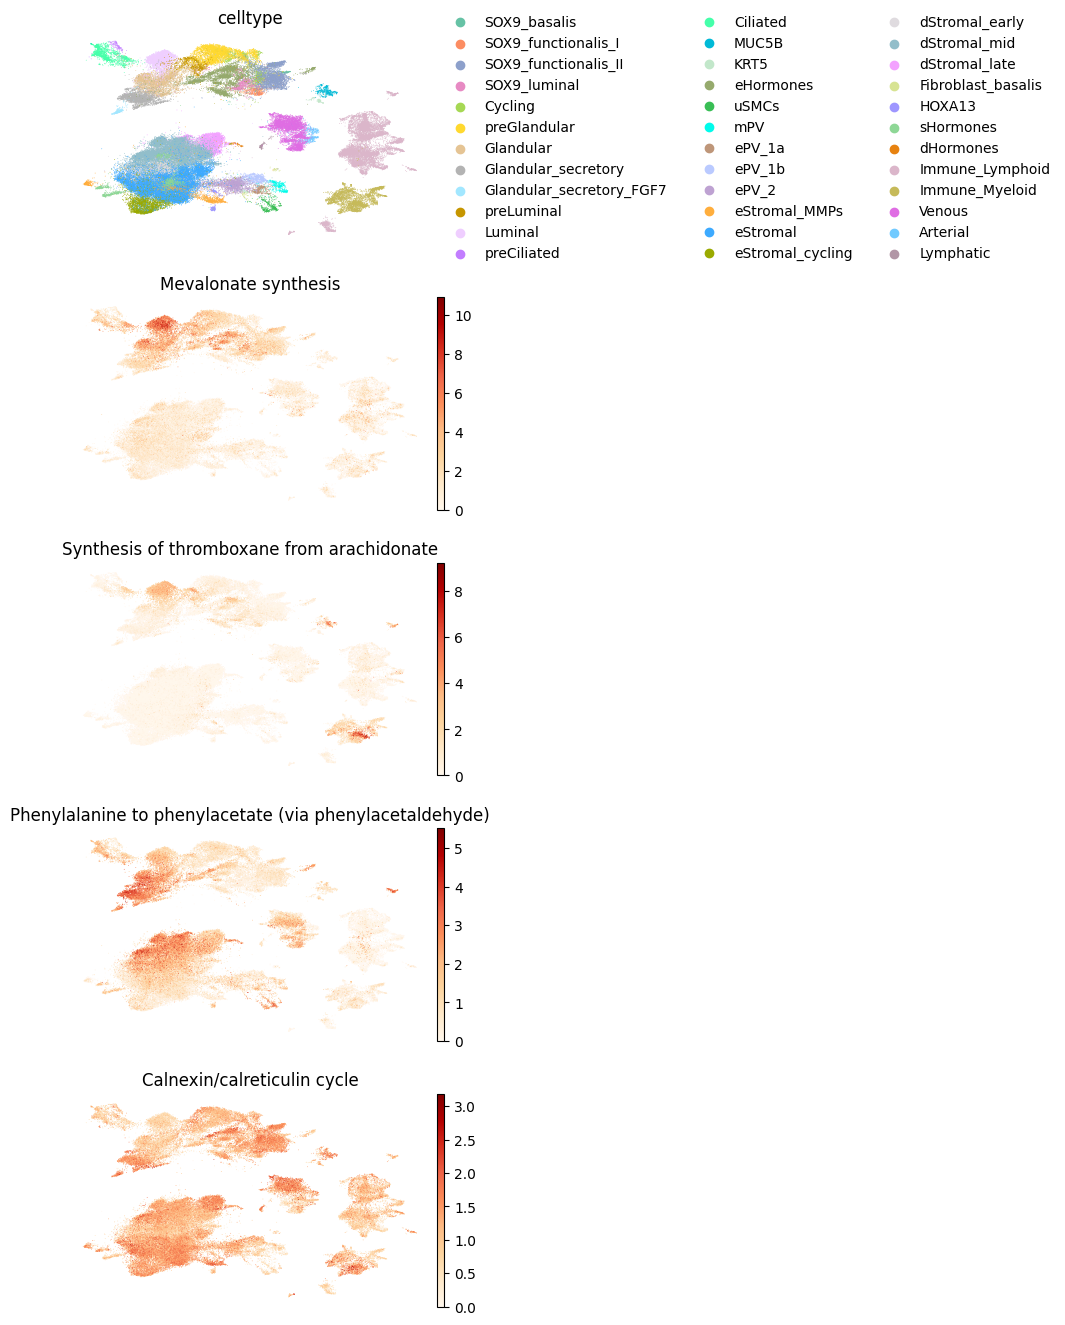

In [10]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + metabolic_tasks,
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + metabolic_tasks],
                cmap='OrRd'
               )

### Violin plots

We can further inspect the metabolic score distribution across single cells per cell type for these tasks.

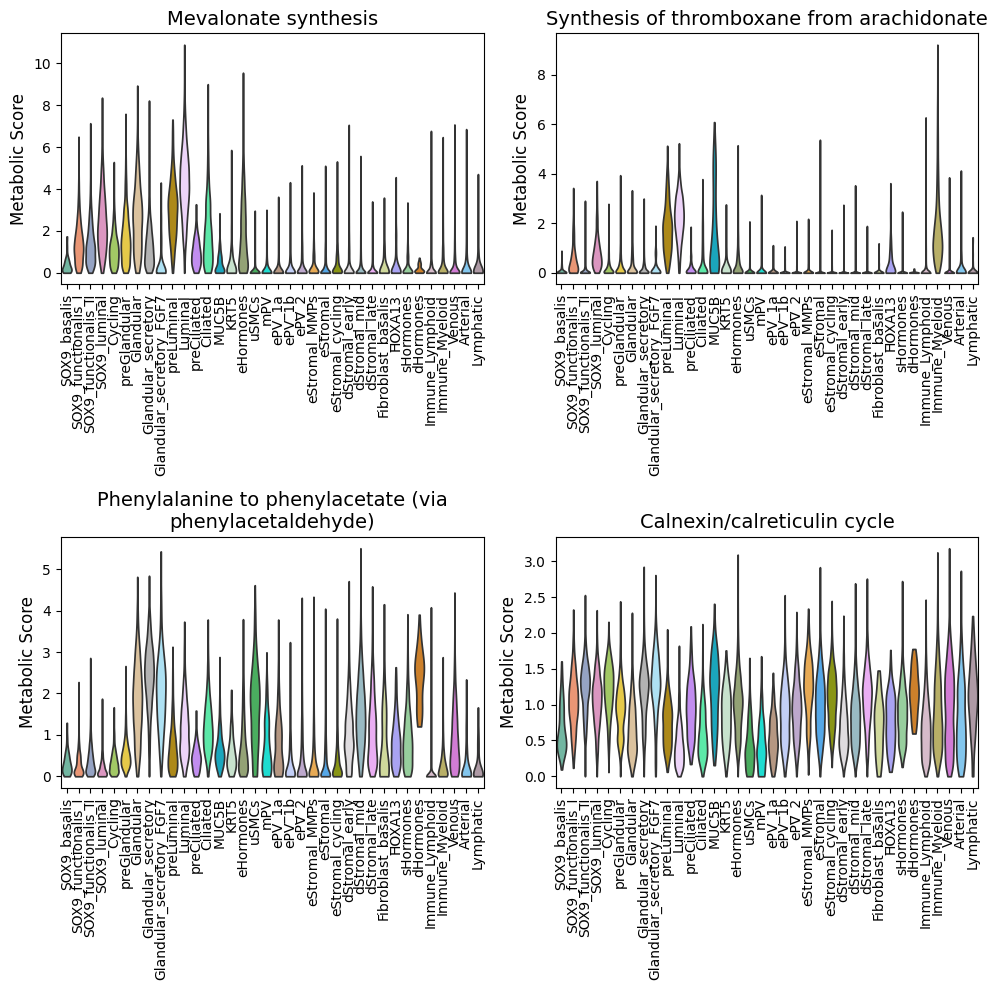

In [11]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=metabolic_tasks,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=2,
                                                         ylabel='Metabolic Score'
                                                        )

Similarly, we can use stacked violin plots. Note that we use ``standard_scale='var'`` to normalize each task by their min and max values. If you prefer visualizing raw scores, remove this parameter.

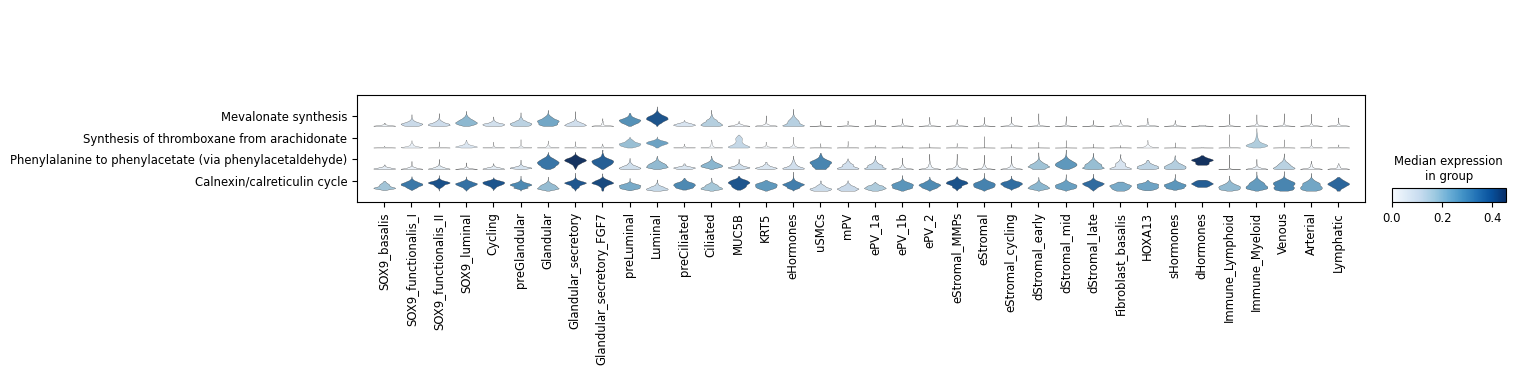

In [12]:
ax = sc.pl.stacked_violin(results['adata'].metabolic_tasks, metabolic_tasks, groupby=cell_group, swap_axes=True, dendrogram=False, standard_scale='var')

### Dot plots

Additionally, we can summarize these activities with the typical dot plot visualizations. Note that we use ``standard_scale='var'`` to normalize each task by their min and max values. If you prefer visualizing raw scores, remove this parameter.

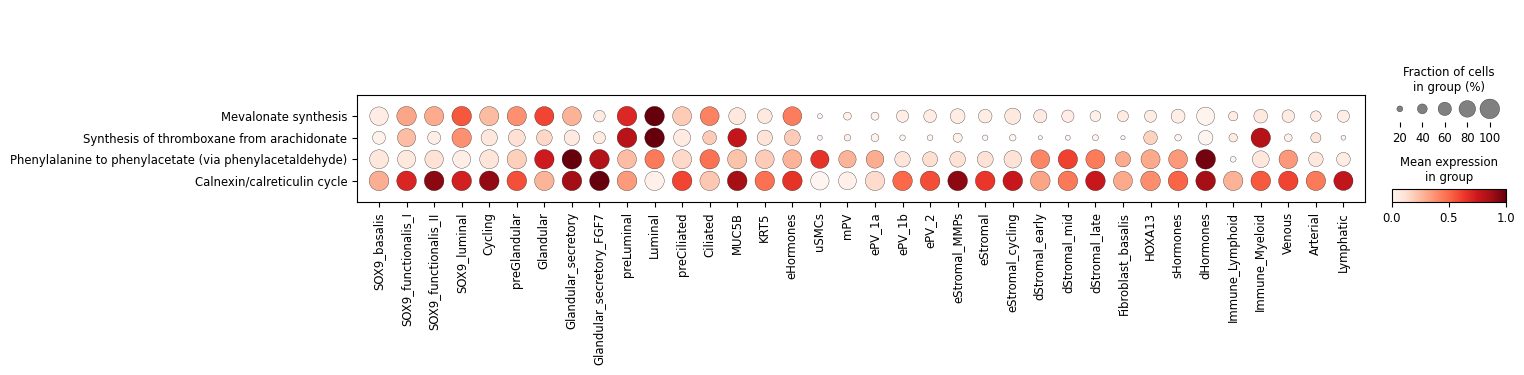

In [13]:
sc.pl.dotplot(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, swap_axes=True, standard_scale='var')

### Heatmaps

We can use Scanpy's heatmap to visualize the activity of individual cells per cell type.

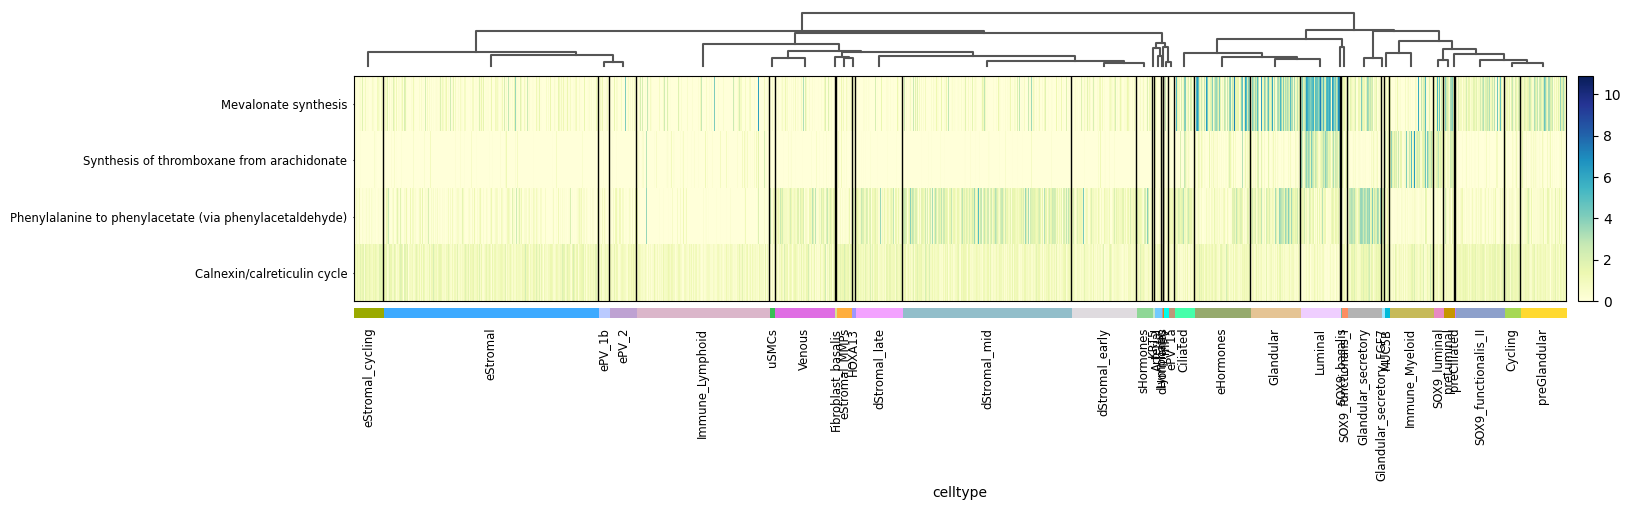

In [14]:
ax = sc.pl.heatmap(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, cmap="YlGnBu", swap_axes=True, dendrogram=True,
                   figsize=(16, 4)
                  )

We can also aggregate metabolic activities into a cell-type level, using a central measure that is robust to outliers (Tuckey's trimean).

In [15]:
agg = sccellfie.expression.aggregation.agg_expression_cells(results['adata'].metabolic_tasks, groupby=cell_group, agg_func='trimean')

In [16]:
agg.head()

Task,(R)-3-Hydroxybutanoate synthesis,3'-Phospho-5'-adenylyl sulfate synthesis,AMP salvage from adenine,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,...,Valine to succinyl-coA,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,gamma-Linolenate synthesis,glyco-cholate synthesis,tauro-cholate synthesis
Arterial,1.545494,0.256560,1.675679,2.481569,1.140274,1.683265,0.870287,1.473789,0.226789,1.058484,...,0.177041,0.285316,1.038388,1.133446,0.354123,0.790606,0.382763,0.235242,0.163742,0.163742
Ciliated,1.344503,1.078283,1.451005,1.929947,0.926791,1.361861,0.898742,1.204373,0.247436,0.885028,...,0.244663,0.200298,1.080395,1.079573,0.478875,0.714021,0.551285,0.438381,0.210721,0.210721
Cycling,2.339640,2.098761,3.000086,3.718694,1.793995,2.478271,1.385080,2.245646,0.331105,1.527862,...,0.298281,0.243763,1.611313,1.814151,0.531332,1.266566,0.602918,0.577959,0.177004,0.177004
Fibroblast_basalis,1.416667,0.240646,1.469132,2.305450,0.964709,1.543950,0.822460,1.391081,0.214616,0.962404,...,0.313859,0.325815,0.958066,1.098681,0.397049,0.760794,0.409347,0.227279,0.136562,0.136562
Glandular,1.420670,3.829955,1.562031,2.227763,1.028959,1.508401,0.876093,1.413924,0.250335,0.911051,...,0.190035,0.211772,1.077158,1.066982,0.470206,0.807817,0.562692,0.681898,0.119519,0.119519


Followed by a min-max normalization to scale values between 0 a 1 per task (Optional).

In [17]:
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

And use seaborn's function to plot our metabolic tasks

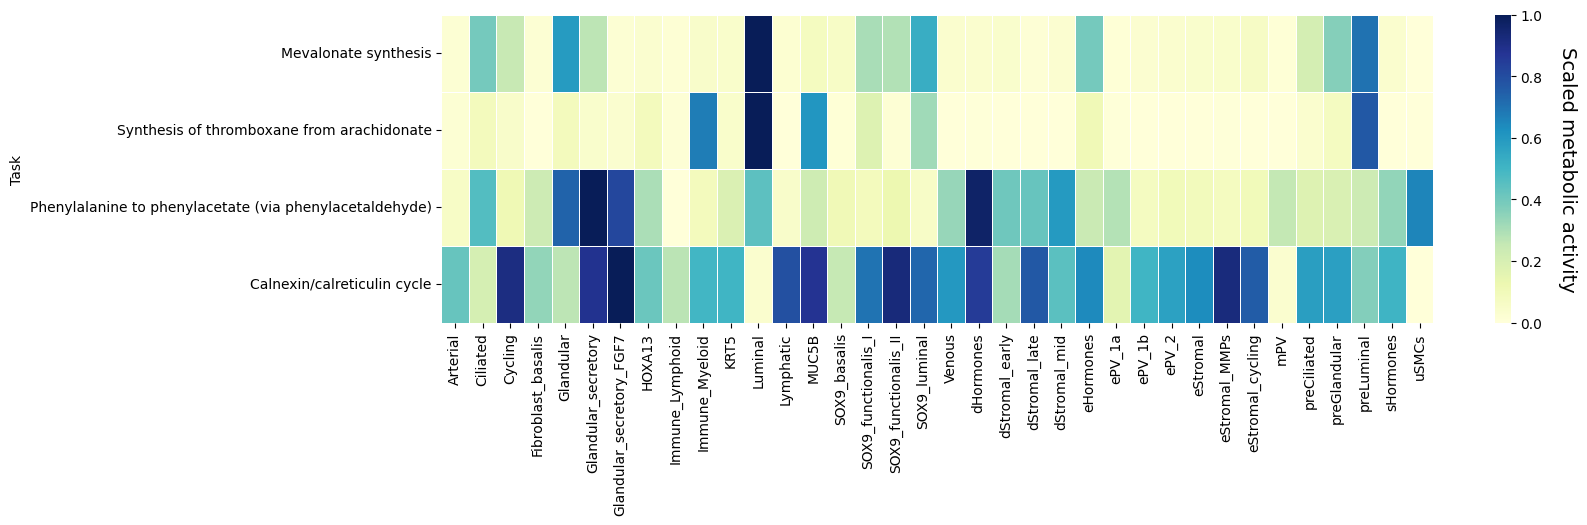

In [18]:
plt.figure(figsize=(16, 4))
g = sns.heatmap(input_df.loc[metabolic_tasks,:], cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1)

cbar = g.collections[0].colorbar
cbar.set_label('Scaled metabolic activity', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation

# Uncomment code below to save figure
# plt.savefig('./figures/Heatmap-Seaborn.pdf', dpi=300, bbox_inches='tight')

### Track plots

The track plot shows the metabolic activities per single cell represented by height, and colors single cells by their cell-type annotations

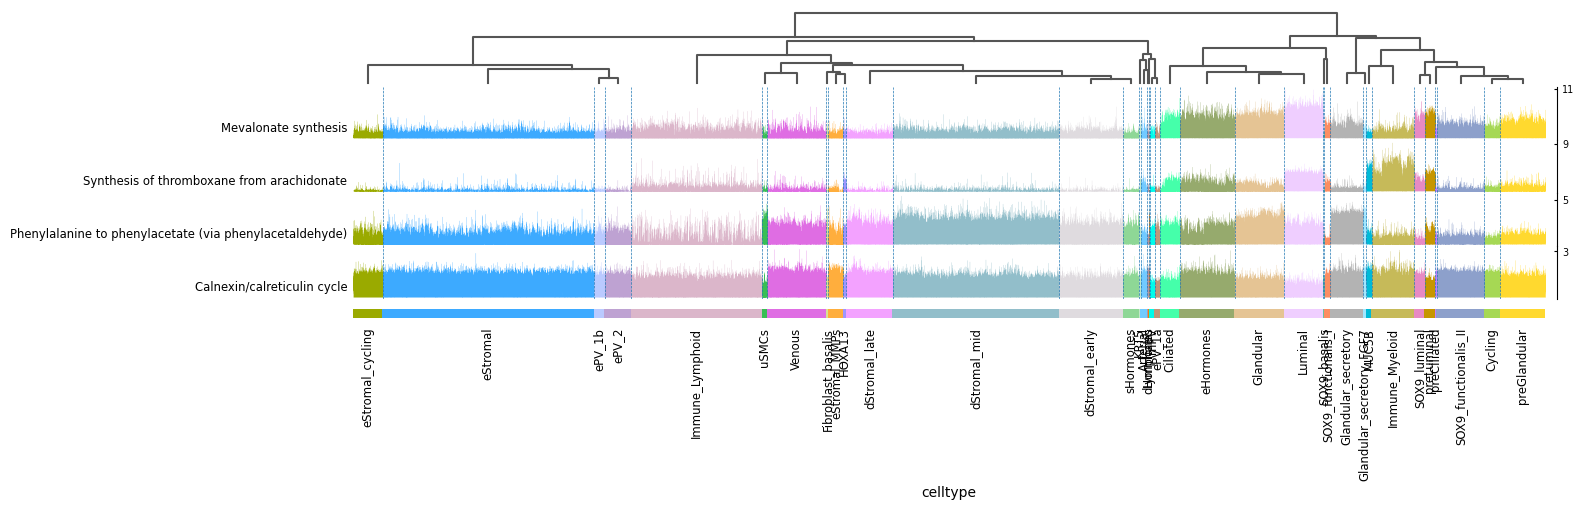

In [19]:
ax = sc.pl.tracksplot(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, dendrogram=True, figsize=(16, 4))

### Radial plots

scCellFie can generate plots summarizing metabolic activities colored by groups of metabolic tasks per cell type.

For this purpose, we first need to manipulate our min-max normalized aggregated data:

In [20]:
df_melted = pd.melt(input_df.reset_index(), id_vars='Task', var_name='cell_type', value_name='scaled_trimean')
df_melted = df_melted.rename(columns={'Task': 'metabolic_task'})

In [21]:
df_melted.head()

,metabolic_task,cell_type,scaled_trimean
0,(R)-3-Hydroxybutanoate synthesis,Arterial,0.283599
1,3'-Phospho-5'-adenylyl sulfate synthesis,Arterial,0.051797
2,AMP salvage from adenine,Arterial,0.305803
3,ATP generation from glucose (hypoxic condition...,Arterial,0.308385
4,ATP regeneration from glucose (normoxic condit...,Arterial,0.314791


We can now visualize the tasks with radial plots. These plots are bar plots where each bar starts from the center of the plot and are arranged in a circular (polar) way. Here, each bar is colored by their major groups, tasks within each category are arranged alphabetically. We can generate a radial plot per each cell type that we are interested in.

In [22]:
cell_types = ['dStromal_mid', 'Glandular', 'Luminal', 'Lymphatic']

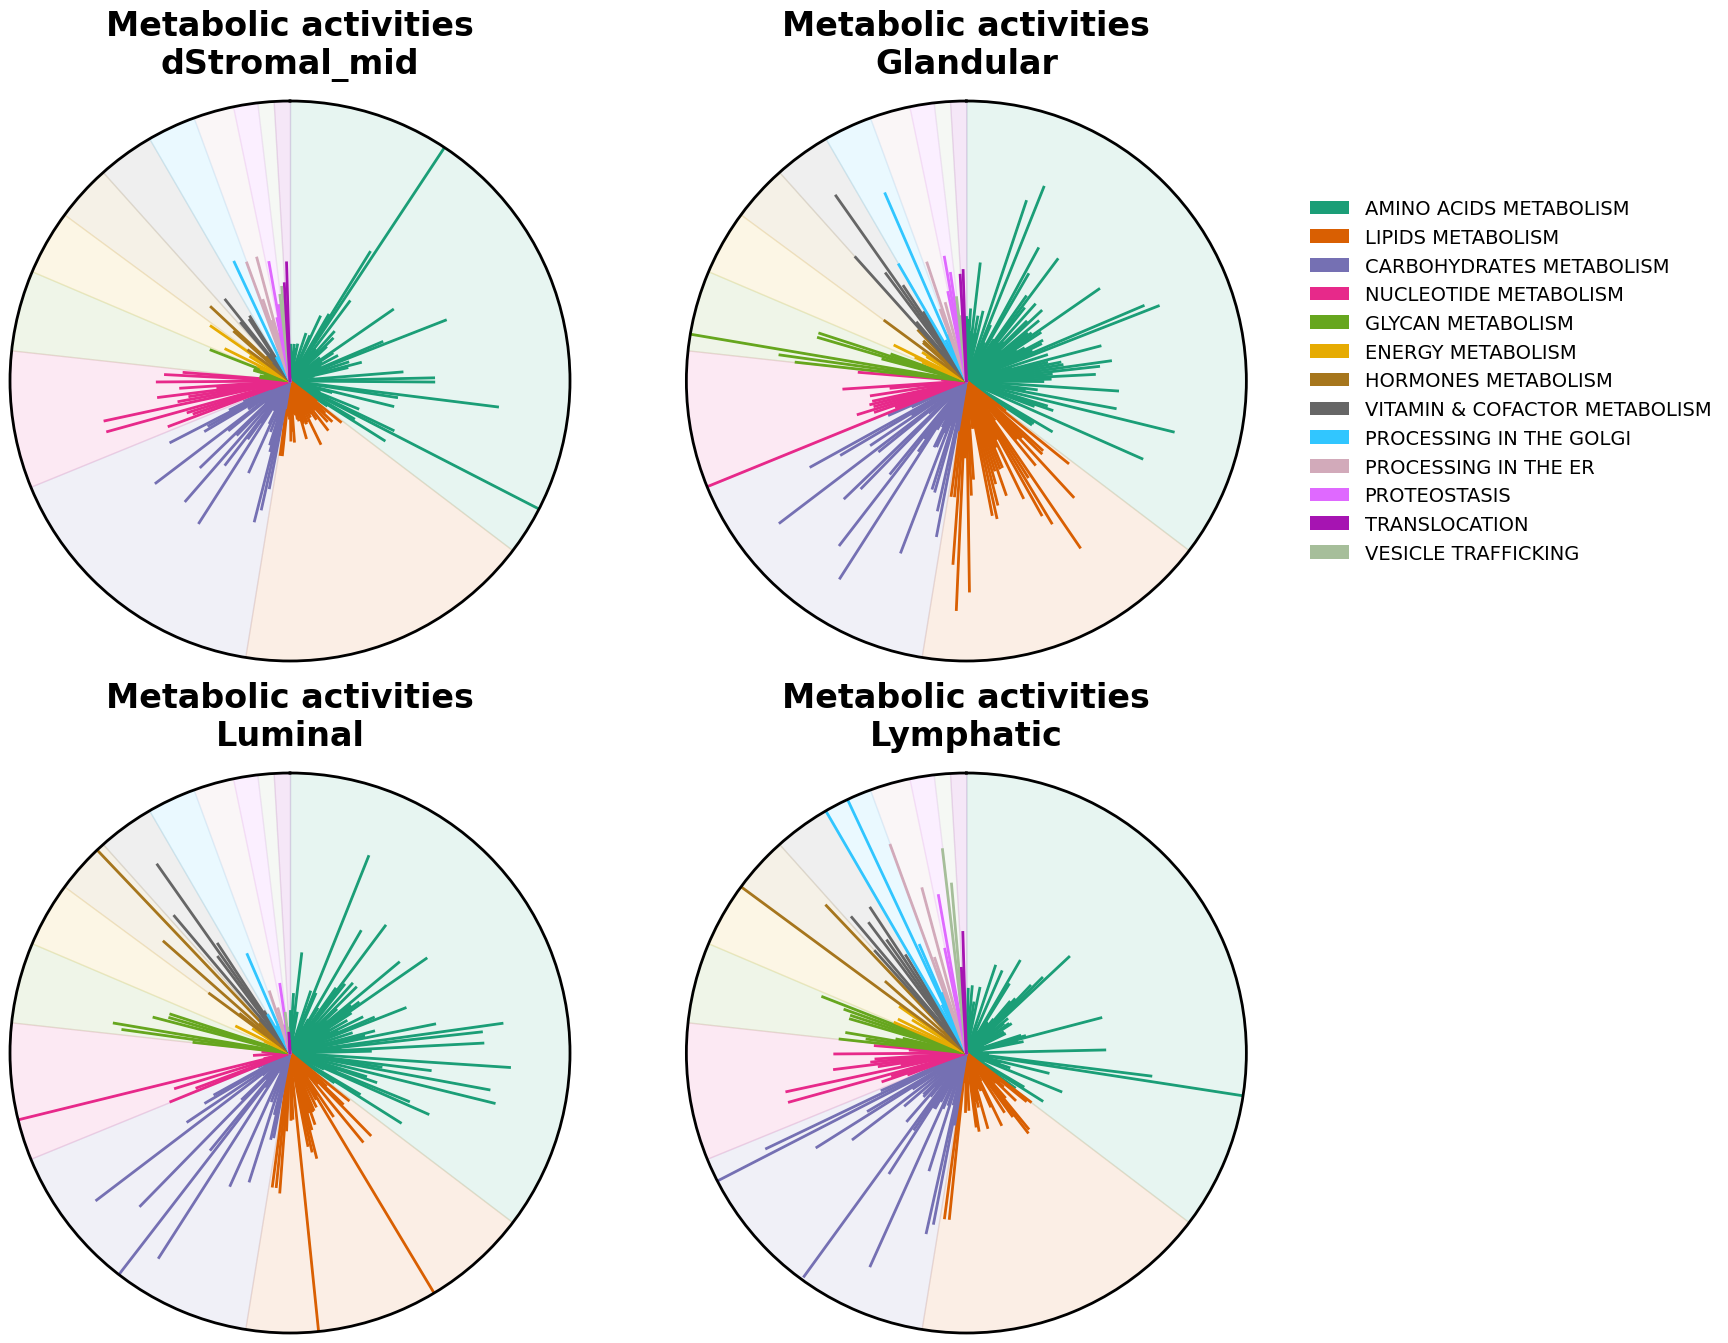

In [23]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(cell_types, [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(df_melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0
                                          )

Alternatively, we can sort tasks by their magnitude using ``sort_by_value=True``. 

<div class="alert alert-info">
<b>Note!</b>

When comparing cell types this will cause that a same metabolic tasks won't receive the same location in one cell type versus another, as each cell type will have a specific task order.

</div> 

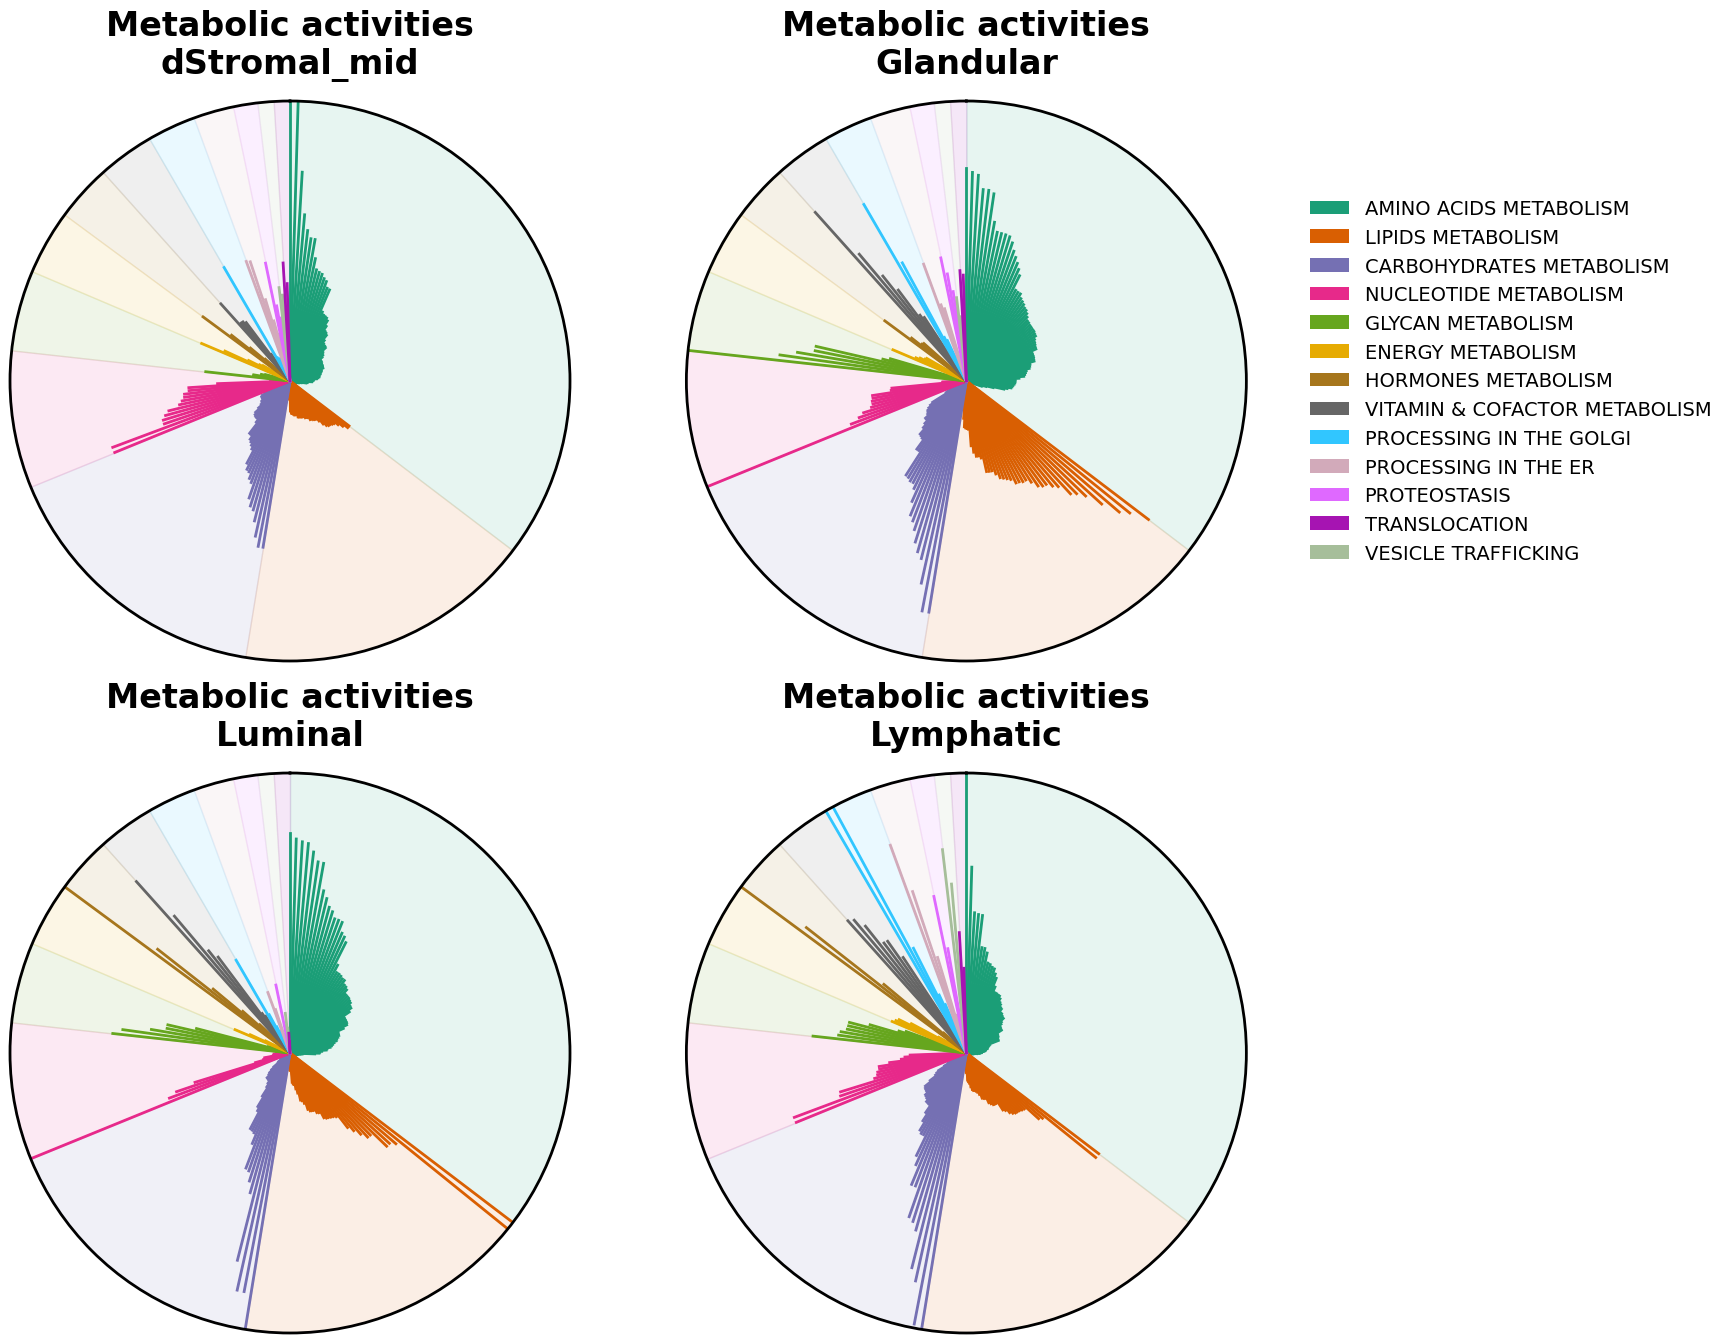

In [24]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(cell_types, [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(df_melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0,
                                          sort_by_value=True
                                          )